# Multimodal Emotion Recognition using Opensmile and Deepface on RAVDESS dataset


In this research, we developed an Emotion Recognition system using two modalities: speech and facial expressions. The speech emotion recognizer (SER) utilized Opensmile to extract features from 1344 audio files, which represented 7 different emotions expressed by 24 actors. We achieved the best accuracy by applying PCA to reduce the dimensionality of the features and training them using a Multi-layer Perceptron (MLP) as a supervised learning algorithm.

Similarly, for the facial emotion recognizer (FER), we processed 1344 videos of 24 actors. Each video was divided into 4 frames, and Deepface was employed to extract Action Units from each frame. PCA was again applied to reduce the feature dimensionality, followed by training the dataset using MLP.

Finally, we combined the features extracted from both modalities (audio and video) and achieved an overall accuracy of 82.60% for classifying the 7 emotions in the dataset. Our results demonstrate that these modalities contain valuable information for detecting users' emotional states, and their combination significantly improved the performance of the system.

## Installing Opensmile & Deepface in your python environment
By executing these commands, you install the respective packages in your Python environment, allowing you to utilize their features and functionalities in your code.



In [ ]:
!pip install opensmile
!pip install deepface

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Accessing your Google Drive
This line mounts the Google Drive to the "/content/drive" directory in the Colab environment. It prompts the user to authenticate and authorize access to their Google Drive account. Once mounted, the user can access and interact with their Google Drive files and directories within the Colab notebook.
And the rest of the code imports necessary libraries and sets up the device for running the code on GPU if available

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import opensmile
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
import pandas as pd
import os
import cv2
from google.colab.patches import cv2_imshow
from deepface import DeepFace
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import IPython.display as ipd
import librosa
from sklearn.metrics import confusion_matrix
from IPython.display import HTML, display
from base64 import b64encode


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Reading Audio & Video Files and extracting their labels

The below code reads audio and video files from specific directories, extracts relevant information from the filenames, converts codes into descriptive labels, filters and stores the data, and creates separate DataFrames for audio and video data.

The RAVDESS dataset consists of audio and video files with 8 different emotions. However, the number of files labeled as '**Neutral**' is relatively low compared to the other emotions. Therefore, we made a decision to exclude the '**Neutral**' emotion and focus our code on the remaining 7 selected emotions.

In [ ]:
# Emotions in the RAVDESS dataset
emotions = {
    '01': 'Neutral',
    '02': 'Calm',
    '03': 'Happy',
    '04': 'Sad',
    '05': 'Angry',
    '06': 'Fearful',
    '07': 'Disgust',
    '08': 'Surprised'
}

# Emotions to be selected
selected_emotions = ["Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"]

import os
import pandas as pd

audio_dir_path = '/content/drive/MyDrive/HS-Project/RAVDESS/Audio_Speech_Actors_01-24'
video_dir_path = '/content/drive/MyDrive/HS-Project/RAVDESS/Video_Speech_Actors_01-24'

data_audio = []
data_video = []

def get_label(code, labels):
    return labels[code - 1]

for folder_path in [audio_dir_path, video_dir_path]:
    for folder in os.listdir(folder_path):
        full_path = os.path.join(folder_path, folder)
        if os.path.isdir(full_path):
            for filename in os.listdir(full_path):
                if filename.endswith('.mp4') or filename.endswith('.wav'):
                    filename_parts = filename[:-4].split('-')
                    filetype = int(filename_parts[0])
                    contenttype = int(filename_parts[1])
                    emotion = int(filename_parts[2])
                    intensity = int(filename_parts[3])
                    sentence = int(filename_parts[4])
                    repetition = int(filename_parts[5])
                    actor = int(filename_parts[6])

                    filetype_label = get_label(filetype, ["full-AV", "video-only", "audio-only"])
                    contenttype_label = get_label(contenttype, ["speech", "song"])
                    emotion_label = get_label(emotion, ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"])
                    intensity_label = get_label(intensity, ["normal", "strong"])
                    sentence_label = get_label(sentence, ["Kids are talking by the door", "Dogs are sitting by the door"])
                    repetition_label = get_label(repetition, ["1st repetition", "2nd repetition"])

                    if emotion_label not in selected_emotions:
                        continue

                    data = {
                        "Filepath": os.path.join(full_path, filename),
                        "Filename": filename[:-4],
                        "File-Type": filetype_label,
                        "Content-Type": contenttype_label,
                        "Emotion": emotion_label,
                        "Intensity": intensity_label,
                        "Sentence": sentence_label,
                        "Repetition": repetition_label
                    }

                    if filename.endswith('.mp4') and filetype_label != "full-AV":
                        data_video.append(data)
                    elif filename.endswith('.wav'):
                        data_audio.append(data)

audio_df = pd.DataFrame(data_audio)
video_df = pd.DataFrame(data_video)


video_df.shape

(1344, 8)

## Emotion Distribution in Audio and Video Data

The code visualizes the distribution of emotions in the audio and video data by creating two bar plots side by side.


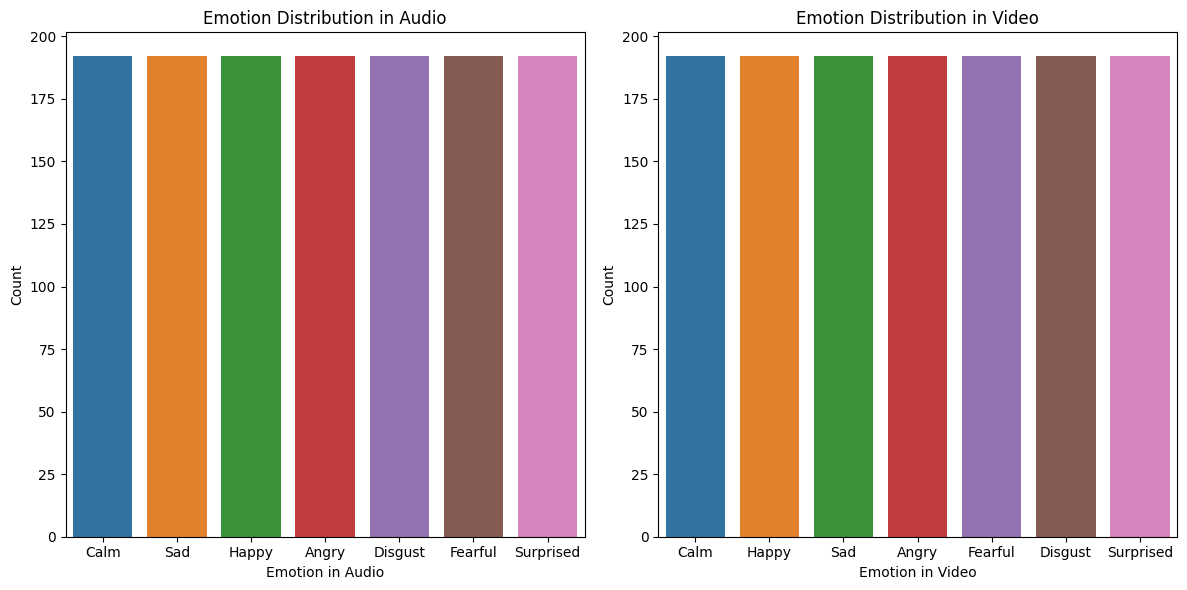

In [ ]:
# Count the occurrences of each emotion category for audio
audio_emotion_counts = audio_df['Emotion'].value_counts()

# Count the occurrences of each emotion category for video
video_emotion_counts = video_df['Emotion'].value_counts()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the bar plot for audio
sns.barplot(x=audio_emotion_counts.index, y=audio_emotion_counts.values, ax=ax1)
ax1.set_xlabel('Emotion in Audio')
ax1.set_ylabel('Count')
ax1.set_title('Emotion Distribution in Audio')

# Plot the bar plot for video
sns.barplot(x=video_emotion_counts.index, y=video_emotion_counts.values, ax=ax2)
ax2.set_xlabel('Emotion in Video')
ax2.set_ylabel('Count')
ax2.set_title('Emotion Distribution in Video')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()


## Visualizing Emotions in Audio: Waveplots, Spectrograms, and Audio Playback

This code displays waveplots, spectrograms, and plays audio files corresponding to different emotions in the audio dataset.



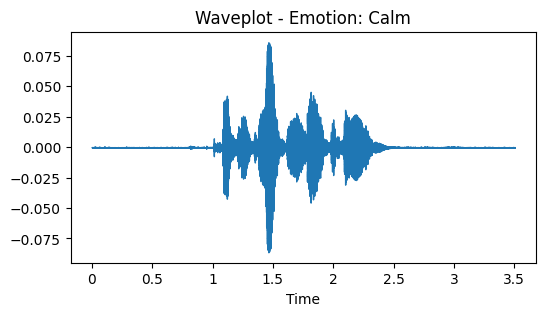

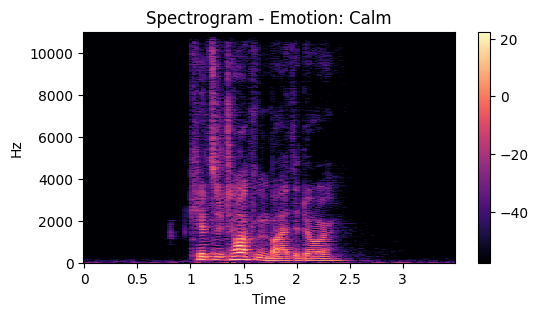

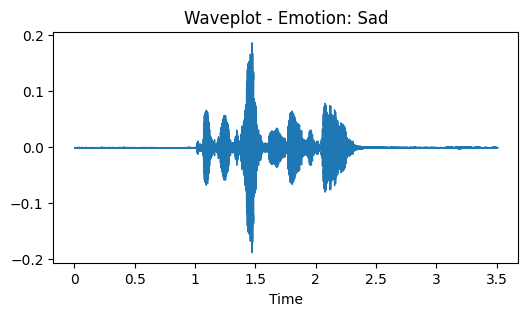

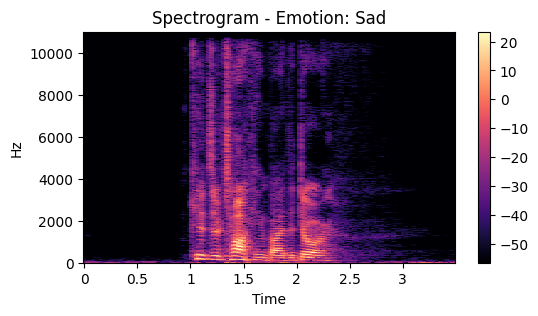

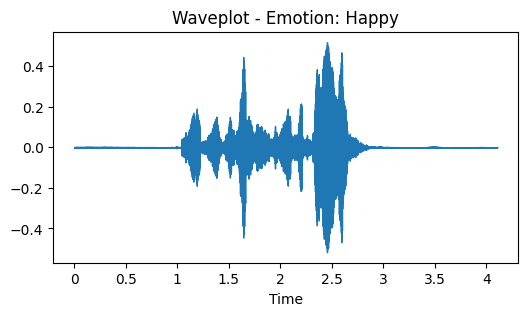

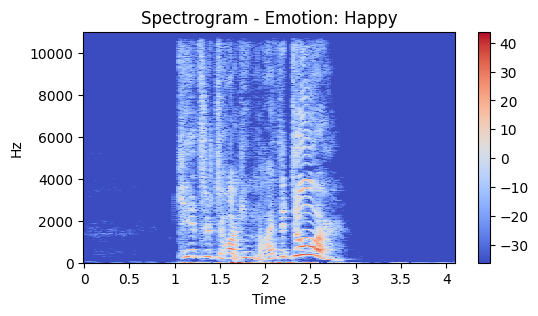

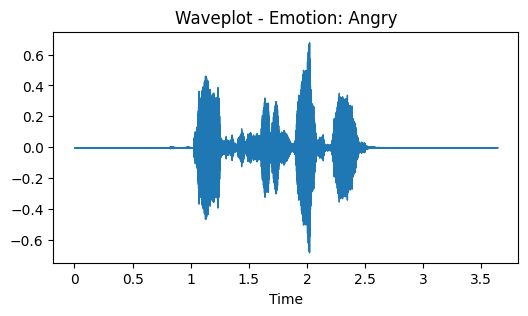

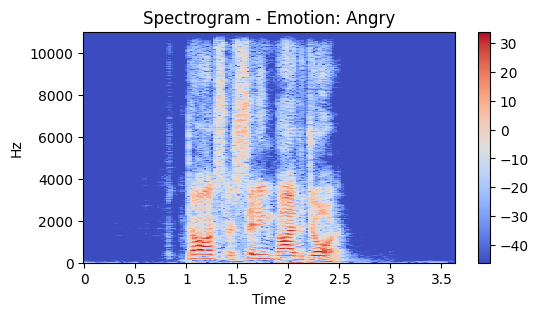

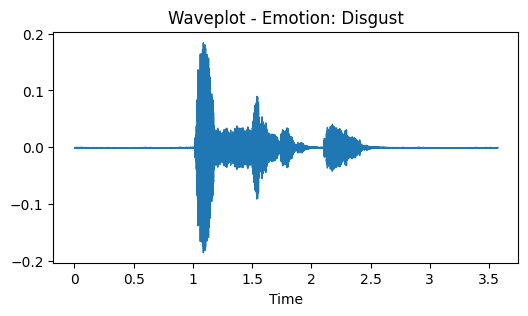

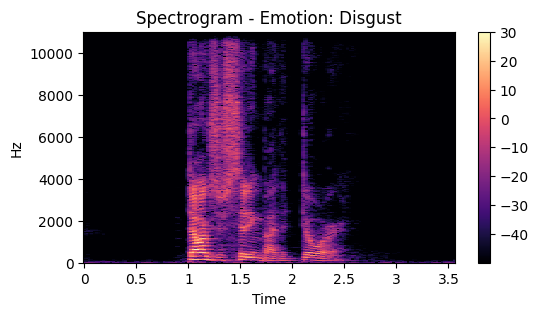

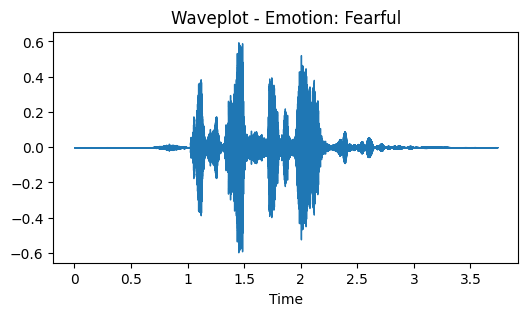

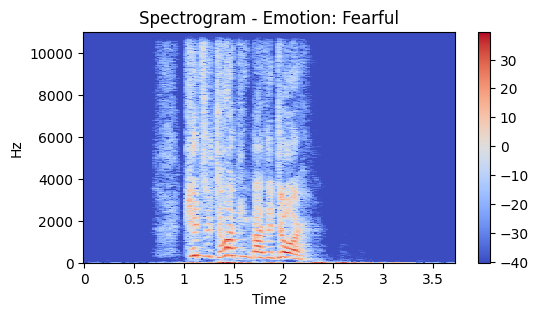

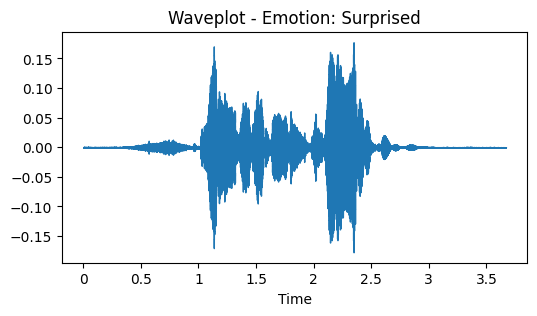

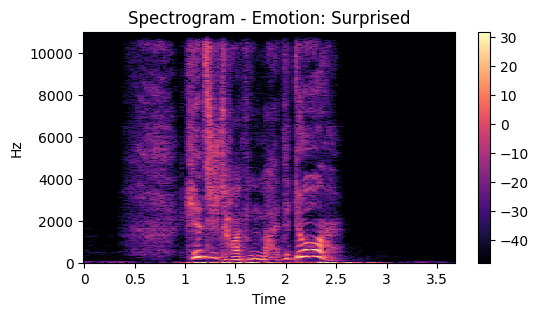

In [ ]:
emotions = audio_df['Emotion'].unique()

for emotion in emotions:
    path = np.array(audio_df['Filepath'][audio_df['Emotion'] == emotion])[0]
    data, sampling_rate = librosa.load(path)

    # Waveplot
    plt.figure(figsize=(6, 3))
    plt.title(f'Waveplot - Emotion: {emotion}')
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.show()

    # Spectrogram
    plt.figure(figsize=(6, 3))
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.title(f'Spectrogram - Emotion: {emotion}')
    librosa.display.specshow(xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
    plt.colorbar()

    # Play Audio
    ipd.display(ipd.Audio(data, rate=sampling_rate))

## Visualizing Emotions in Audio: Video Playback

The below code begins by extracting the unique emotions from the video dataset. For each emotion, the corresponding video filepath is retrieved. The video is then opened and read as binary using the file path.


In [ ]:
emotions = video_df['Emotion'].unique()

for emotion in emotions:
    video_path = np.array(video_df['Filepath'][video_df['Emotion'] == emotion])[0]

    with open(video_path, 'rb') as file:
        mp4 = file.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

    display(HTML(f"<h2>Emotion: {emotion}</h2>"))
    display(HTML("""<video width=400 controls><source src="%s" type="video/mp4"></video>""" % data_url))


## Processing of Audio Files for Feature Extraction with OpenSmile (Terminal Execution)

The below shell script performs a batch processing of audio files in the specified directory. It iterates through subfolders within the main folder and searches for WAV files. For each WAV file found, it extracts features using the SMILExtract (Opensmile tool) and saves the extracted features to a corresponding CSV file.

The configuration file used for feature extraction is "IS09_emotion.conf". The resulting CSV files are named with a prefix "features_" followed by the original filename of the audio file.


---


The code provided cannot be executed directly in Google Colab. Instead, we ran it on our local machines using the terminal.

In [ ]:
#!/bin/sh
# main_folder="/Users/azam/Desktop/HS-Project/RAVDESS/Audio_Speech_Actors_01-24"

# for subfolder in "$main_folder"/*; do
#   if [ -d "$subfolder" ]; then
#     for inner_subfolder in "$subfolder"/*; do
#         find "$inner_subfolder" -type f -name "*.wav" -print0 | while read -r -d '' file; do
#           filename=$(basename "$file" .wav)
#           command="SMILExtract -C /Users/azam/Desktop/HS-Project/opensmile-master/config/is09-13/IS09_emotion.conf -I $file -csvoutput /Users/azam/Desktop/HS-Project/CSV/features_$filename.csv"
#           eval "$command"
#         done
#     done
#   fi
# done

### Reading Audio features from CSV Files

The below code processes multiple CSV files located in the specified directory (audio_CSV). It reads each CSV file into a DataFrame and performs some operations on the data.

So at the end we have a Dataframe with **1344** rows (The number of audio files) and **386** (The number of extracted features for each file) columns.


In [ ]:
# Path to the CSV file
csv_file_path = '/content/drive/MyDrive/HS-Project/audio_CSV'

dfs = []
combined_audio_df=[]

def get_label(code, labels):
    return labels[code-1]

# Read the CSV file into a DataFrame
for file in os.listdir(csv_file_path):
    if file.endswith('.csv'):

        filename_parts = file[:-4].split('-')
        emotion = int(filename_parts[2])

        file_path = os.path.join(csv_file_path, file)
        features_df = pd.read_csv(file_path, delimiter=";")

        features_df['Name'] = file.split('_')[1][3:]
        features_df['Emotion']= get_label(emotion, ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"])

        if emotion!= 1:
          dfs.append(features_df)

combined_audio_df = pd.concat(dfs, ignore_index=True)

# Exclude the redundant columns
columns_to_exclude = ['name', 'frameTime']
combined_audio_df = combined_audio_df.drop(columns=columns_to_exclude)
combined_audio_df

pcm_RMSenergy_sma_max  pcm_RMSenergy_sma_min  pcm_RMSenergy_sma_range  \
0                  0.045743               0.000011                 0.045732   
1                  0.006206               0.000010                 0.006196   
2                  0.002736               0.000009                 0.002727   
3                  0.001795               0.000007                 0.001788   
4                  0.022139               0.000008                 0.022130   
...                     ...                    ...                      ...   
1339               0.001688               0.000010                 0.001679   
1340               0.001449               0.000008                 0.001441   
1341               0.029199               0.000006                 0.029193   
1342               0.002924               0.000008                 0.002916   
1343               0.019064               0.000011                 0.019053   

      pcm_RMSenergy_sma_maxPos  pcm_RMSenergy_sma_minPos  \
0                          161                        61   
1                          122                        10   
2                          162                       332   
3                          123                        26   
4                          143                       329   
...                        ...                       ...   
1339                       212                         2   
1340                       130                       349   
1341                       156                        29   
1342                       158                        69   
1343                       166                        51   

      pcm_RMSenergy_sma_amean  pcm_RMSenergy_sma_linregc1  \
0                    0.004133               -7.642961e-06   
1                    0.000766               -1.160358e-06   
2                    0.000186               -2.621572e-07   
3                    0.000118               -1.697694e-07   
4                    0.002847               -4.087483e-06   
...                       ...                         ...   
1339                 0.000232                5.790019e-08   
1340                 0.000129               -1.162290e-07   
1341                 0.002399               -4.643185e-06   
1342                 0.000185               -3.513464e-07   
1343                 0.001508               -2.996047e-06   

      pcm_RMSenergy_sma_linregc2  pcm_RMSenergy_sma_linregerrQ  \
0                       0.005620                  5.248361e-05   
1                       0.000976                  1.246841e-06   
2                       0.000235                  1.286417e-07   
3                       0.000151                  4.218651e-08   
4                       0.003581                  2.148146e-05   
...                          ...                           ...   
1339                    0.000220                  1.049647e-07   
1340                    0.000150                  3.831682e-08   
1341                    0.003309                  1.651130e-05   
1342                    0.000249                  1.761837e-07   
1343                    0.002065                  1.052751e-05   

      pcm_RMSenergy_sma_stddev  ...  F0_sma_de_minPos  F0_sma_de_amean  \
0                     0.007295  ...                30     1.207069e+00   
1                     0.001123  ...               324     1.197891e-08   
2                     0.000360  ...               226    -7.460488e-09   
3                     0.000206  ...               150    -2.731231e-08   
4                     0.004654  ...               235     4.371007e-08   
...                        ...  ...               ...              ...   
1339                  0.000324  ...               362    -1.285643e-09   
1340                  0.000196  ...               126     2.811084e-08   
1341                  0.004097  ...               384     1.224142e+00   
1342                  0.000421  ...               207    -6.013829e-09

## Processing of Video Files for Feature Extraction



### Selecting 4 Frames from each Video

The below code iterates through the frames, setting the frame position and reading each frame. If a frame is successfully read, it can be processed or used as needed. The selected frames are stored in a list until the desired number of frames (num_frames = 4) is reached or all frames have been processed.



In [ ]:

def select_frames(video_path, num_frames=4):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps

    # Calculate the frame interval to select the desired number of frames
    frame_interval = int(frame_count / num_frames)

    selected_frames = []

    for i in range(0, frame_count, frame_interval):
        # Set the frame position
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)

        # Read the frame
        ret, frame = cap.read()

        if ret:

            # Process the frame as needed
            selected_frames.append(frame)

        if len(selected_frames) == num_frames:
            break

    # Release the video capture object
    cap.release()

    return selected_frames


### Video Frame Feature Extraction with **DeepFace**

The given code defines a function `extract_video_frame_features` that extracts features from selected frames of a video using the DeepFace library.

The code uses DeepFace for facial feature extraction and OpenCV for face detection and visualization. And because this process is time-consuming, the extracted features are saved as CSV files to be used for further analysis or processing multiple times.

Then, the provided code iterates over a DataFrame, video_df, containing information about videos, and performs feature extraction on each video by calling the select_frames and extract_video_frame_features functions.

The extracted features from each video's frames are then aggregated into a single array.

In [ ]:

def extract_video_frame_features(video_path, video_filename, selected_frames):

  features = []
  features_vector = []

  for frame in selected_frames:
      # # Extract features using DeepFace
      result = DeepFace.represent(frame, model_name='Facenet512', enforce_detection=False)
      features.append(result[0]["embedding"])

  features_vector = np.concatenate(features)
  features_df = pd.DataFrame(features_vector)

  file_path = '/content/drive/MyDrive/HS-Project/video_CSV/' + video_filename + '.csv'
  features_df.to_csv(file_path, index=False)

  return features_vector

# Run the above methode
video_features = []

for index, row in video_df.iterrows():
    print(index)
    video_path = row['Filepath']
    video_filename = row['Filename']
    selected_frames = select_frames(video_path, num_frames=4)
    frame_features = extract_video_frame_features(video_path, video_filename, selected_frames)
    video_features.append(frame_features)

video_features = np.vstack(video_features)

1/1 [==============================] - 0s 53ms/step


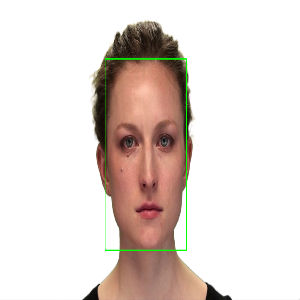

1/1 [==============================] - 0s 31ms/step


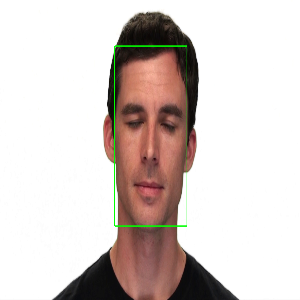

1/1 [==============================] - 0s 37ms/step


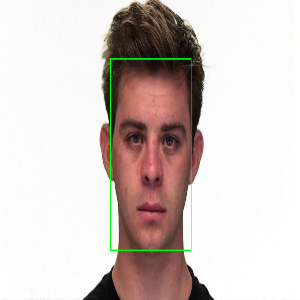

1/1 [==============================] - 0s 30ms/step


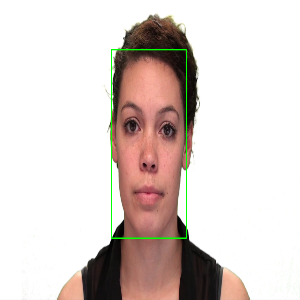

1/1 [==============================] - 0s 32ms/step


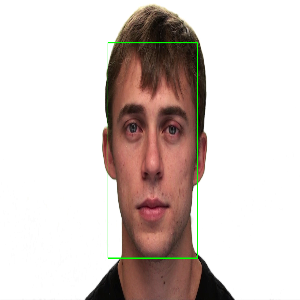

1/1 [==============================] - 0s 34ms/step


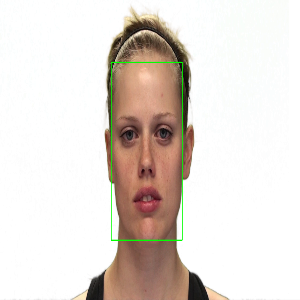

1/1 [==============================] - 0s 33ms/step


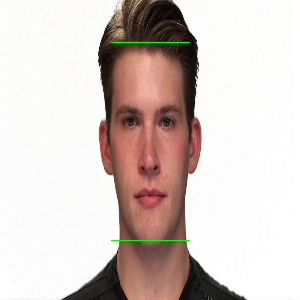

1/1 [==============================] - 0s 48ms/step


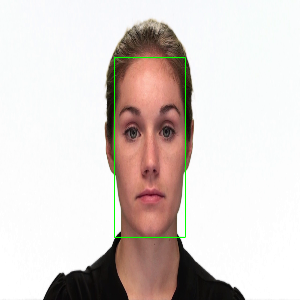

1/1 [==============================] - 0s 34ms/step


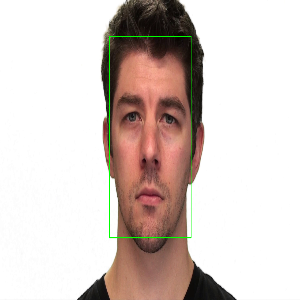

1/1 [==============================] - 0s 30ms/step


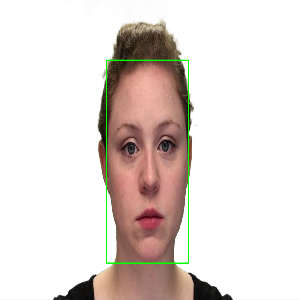

1/1 [==============================] - 0s 34ms/step


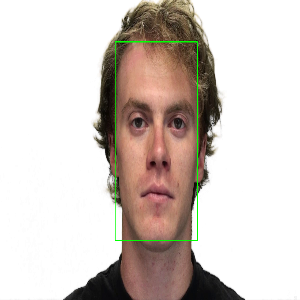

1/1 [==============================] - 0s 32ms/step


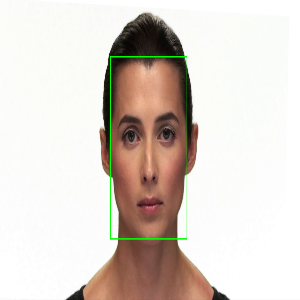

1/1 [==============================] - 0s 57ms/step


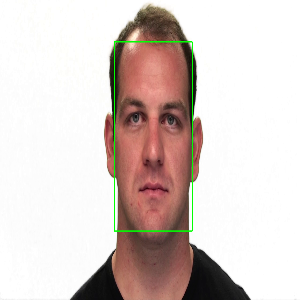

1/1 [==============================] - 0s 31ms/step


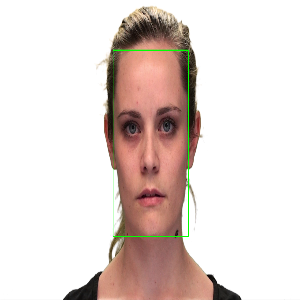

1/1 [==============================] - 0s 57ms/step


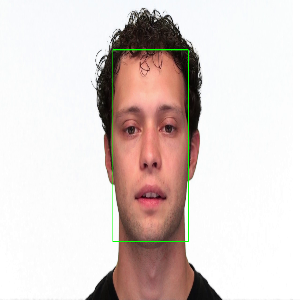

1/1 [==============================] - 0s 31ms/step


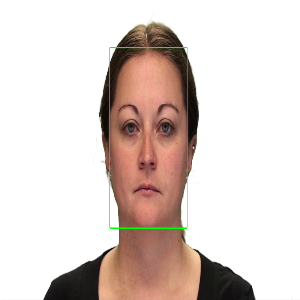

1/1 [==============================] - 0s 79ms/step


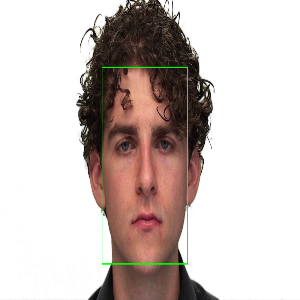

1/1 [==============================] - 0s 48ms/step


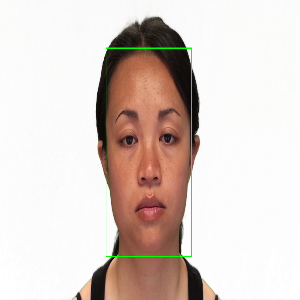

1/1 [==============================] - 0s 40ms/step


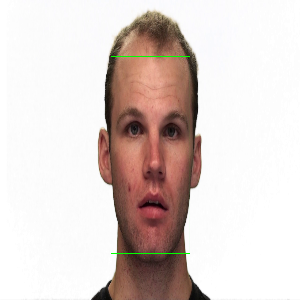

1/1 [==============================] - 0s 31ms/step


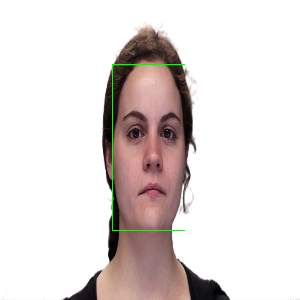

1/1 [==============================] - 0s 32ms/step


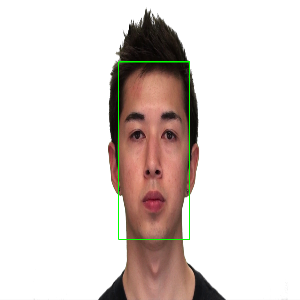

1/1 [==============================] - 0s 31ms/step


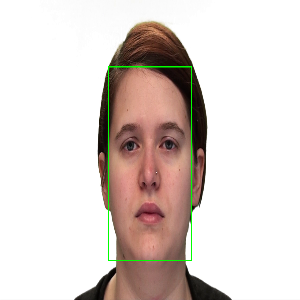

1/1 [==============================] - 0s 65ms/step


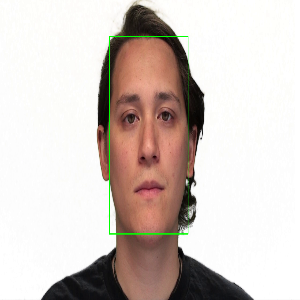

1/1 [==============================] - 0s 37ms/step


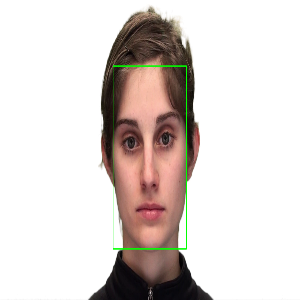

In [ ]:
def face_detection_visualisation(video_path, selected_frames):

  features = []
  features_vector = []

  for frame in selected_frames:

      # Detect faces in the frame
      faces = DeepFace.extract_faces(frame, detector_backend='mtcnn')

      # Draw bounding boxes around the detected faces
      if len(faces) > 0:
        for face in faces:
            facial_area = face['facial_area']
            x = facial_area['x']
            y = facial_area['y']
            w = facial_area['w']
            h = facial_area['h']

            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            resized_frame = cv2.resize(frame, (300, 300))
            cv2_imshow(resized_frame)

  cv2.destroyAllWindows()

# Run the above methode
main_folder = '/content/drive/MyDrive/HS-Project/RAVDESS/Video_Speech_Actors_01-24'

for folder in os.listdir(main_folder):
    folder_path = os.path.join(main_folder, folder)

    files = os.listdir(folder_path)

    file_path = os.path.join(folder_path, files[0])
    selected_frames = select_frames(file_path, num_frames=1)
    frame_features = face_detection_visualisation(file_path, selected_frames)



### Reading Video features from CSV files

The provided code reads multiple CSV files from a specified directory and compiles them into a single DataFrame, combined_video_df, after performing some data transformations. The CSV files are assumed to contain video features in a transposed format.

We have **1344** CSV files, each containing **2048** (512 for each frame) video features, and combines them into a single DataFrame called combined_video_df. The resulting DataFrame has 1344 rows and 2048 columns, representing the compiled video features from all the CSV files.

In [ ]:
# Path to the CSV file
csv_file_path = '/content/drive/MyDrive/HS-Project/video_CSV'

dfs = []

def get_label(code, labels):
    return labels[code-1]

# Read the CSV file into a DataFrame

for file in os.listdir(csv_file_path):
    if file.endswith('.csv'):

        filename_parts = file[:-4].split('-')
        emotion = int(filename_parts[2])

        file_path = os.path.join(csv_file_path, file)
        features_df = pd.read_csv(file_path)
        features_df = features_df.transpose()

        features_df['Name'] = file[3:]
        features_df['Emotion']= get_label(emotion, ["Neutral", "Calm", "Happy", "Sad", "Angry", "Fearful", "Disgust", "Surprised"])

        if emotion!= 1:
          dfs.append(features_df)

combined_video_df = pd.concat(dfs, ignore_index=True)
combined_video_df


0         1         2         3         4         5         6  \
0    -0.468794  1.866126  0.091617 -0.557320  0.198153 -0.022780 -0.798947   
1    -0.532998  1.879532 -0.025594 -0.235354  0.028377 -0.092048 -0.637653   
2    -0.413515  0.735364 -0.470379 -0.108575  0.631510 -0.404845 -0.550534   
3     0.208667  0.884568  0.377286 -0.316372 -0.638435  0.153425 -0.631772   
4     0.022374  0.928960  0.385703 -0.071646 -0.724024  0.219016 -0.808954   
...        ...       ...       ...       ...       ...       ...       ...   
1339 -0.193036  0.194551 -0.954916  0.362400  1.210387  1.373447  0.037173   
1340  0.301757 -1.461163 -1.546155 -1.175421  0.029273 -0.196423  0.883209   
1341  0.504375 -1.361977 -1.244996 -2.007396  0.034289  0.453562  0.937662   
1342 -0.849366  0.015541 -1.288400 -0.488954  0.808292  1.130301  0.459685   
1343 -0.180750 -0.481957 -0.902379  0.536659  0.972673  0.714900 -0.188392   

             7         8         9  ...      2040      2041      2042  \
0     0.782473 -0.055416  0.708996  ...  0.040733 -2.392364 -1.104303   
1     1.173934 -0.116778  0.831939  ...  1.017739 -2.226407 -1.918818   
2     1.241390 -0.558706 -0.423141  ... -0.471480 -1.158381 -1.242965   
3     1.263456  0.391640 -0.286384  ...  0.207540 -2.314663 -1.115253   
4     1.096275  0.834391 -0.105315  ...  0.363170 -2.499583 -1.996525   
...        ...       ...       ...  ...       ...       ...       ...   
1339  0.144069 -0.462802  0.590769  ... -0.058109  0.740937 -0.866196   
1340  0.554084 -1.983185  1.799178  ... -0.636140  0.069868 -1.174563   
1341  0.890396 -2.102313  1.426240  ... -0.482549 -0.006654  0.047077   
1342  0.376275 -1.567057  1.081619  ... -1.124428  0.398674 -1.181250   
1343  1.180842 -0.385151  0.981581  ... -0.835634  0.230893 -1.317084   

          2043      2044      2045      2046      2047                   Name  \
0    -0.070568 -0.937695  1.298755  0.434841  0.420186  01-02-01-01-01-16.csv   
1    -0.526874 -0.928016  0.700409  1.417457  0.937133  01-02-01-02-01-16.csv   
2    -0.874603 -1.325953 -0.759889  1.338040  0.720072  01-02-01-01-02-16.csv   
3    -0.536999 -1.301862  1.159078  0.963914  0.331467  01-02-02-01-02-16.csv   
4    -0.472898 -1.013182  0.259666  1.162539  0.771030  01-02-02-01-01-16.csv   
...        ...       ...       ...       ...       ...                    ...   
1339  2.453231 -0.111537 -1.489753  0.921774  0.485850  01-08-01-02-02-15.csv   
1340  1.398593 -0.464828  0.406727  0.099922  0.180929  01-08-02-01-02-15.csv   
1341  0.004944  0.320926 -0.107534  0.335087 -0.146693  01-08-01-02-01-15.csv   
1342  1.437886 -0.384227 -0.632398  0.344799  0.880804  01-08-02-02-01-15.csv   
1343  1.244137 -0.277757  0.252254  0.073176  0.318963  01-08-02-02-02-15.csv   

        Emotion  
0          Calm  
1          Calm  
2          Calm  
3          Calm  
4          Calm  
...         ...  
1339  Surprised  
1340  Surprised  
1341  Surprised  
1342  Surprised  
1343  Surprised  

[1344 rows x 2050 columns]

## Merging Audio and Video Dataframes

Finally, the below code merges two DataFrames, `combined_audio_df` and `combined_video_df`, based on a common column named '**Name**'. The merging is done using an inner join, which keeps only the rows that have matching values in both DataFrames.

In [ ]:
# Merge Audio & Video dataframes
final_df = pd.merge(combined_audio_df, combined_video_df, on='Name', how='inner')

print("Shape of final dataframe:", final_df.shape)

Shape of final dataframe: (1344, 2435)


In [ ]:
audio_labels = combined_audio_df['Emotion']
video_labels = combined_video_df['Emotion']
final_labels = final_df['Emotion_y']

columns_to_exclude = ['Emotion_y','Name','Emotion_x']
final_df = final_df.drop(columns=columns_to_exclude)


columns_to_exclude = ['Name', 'Emotion']
combined_audio_df = combined_audio_df.drop(columns=columns_to_exclude)

columns_to_exclude = ['Name', 'Emotion']
combined_video_df = combined_video_df.drop(columns=columns_to_exclude)



## Classification Accuracy of MLP Model on **Audio** Dataframe using PCA


In [ ]:
df1 = combined_audio_df

scaler = StandardScaler()
scaled_df1 = scaler.fit_transform(df1)

n = 50
pca = PCA(n_components=n)

pca_df1 = pca.fit_transform(scaled_df1)

X_train1, X_test1, y_train1, y_test1 = train_test_split(pca_df1, audio_labels, test_size=0.2)

model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300, 200, 50), learning_rate='adaptive', max_iter=700)

model.fit(X_train1, y_train1)
y_pred1 = model.predict(X_test1)
accuracy1 = accuracy_score(y_true=y_test1, y_pred=y_pred1)

print("Accuracy for combined_audio_df: {:.2f}%".format(accuracy1 * 100))


Accuracy for combined_audio_df: 71.00%


## Classification Accuracy of MLP Model on **Video** Dataframe using PCA


In [ ]:
df2 = combined_video_df

scaler = StandardScaler()

scaled_df2 = scaler.fit_transform(df2)

n = 100
pca = PCA(n_components=n)

pca_df2 = pca.fit_transform(scaled_df2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(pca_df2, video_labels, test_size=0.2)

model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300, 200, 50), learning_rate='adaptive', max_iter=700)

model.fit(X_train2, y_train2)
y_pred2 = model.predict(X_test2)
accuracy2 = accuracy_score(y_true=y_test2, y_pred=y_pred2)

print("Accuracy for combined_video_df: {:.2f}%".format(accuracy2 * 100))


Accuracy for combined_video_df: 70.63%


## Classification Accuracy of MLP Model on **combination of Audio & Video** Dataframes using PCA

In [ ]:

df3 = final_df

scaler = StandardScaler()

df3.columns = df3.columns.astype(str)
scaled_df3 = scaler.fit_transform(df3)

n = 100
pca = PCA(n_components=n)

pca_df3 = pca.fit_transform(scaled_df3)

X_train3, X_test3, y_train3, y_test3 = train_test_split(scaled_df3, final_labels, test_size=0.2)

model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300, 200, 50), learning_rate='adaptive', max_iter=700)

model.fit(X_train3, y_train3)
y_pred3 = model.predict(X_test3)
accuracy3 = accuracy_score(y_true=y_test3, y_pred=y_pred3)

print("Accuracy for final_df: {:.2f}%".format(accuracy3 * 100))


Accuracy for final_df: 89.96%


## Comparison of MLP Classifier Accuracy on Different Dataframes

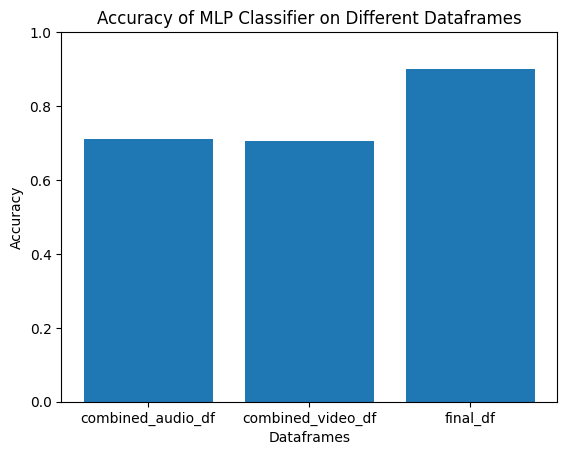

In [ ]:
import matplotlib.pyplot as plt

accuracies = [accuracy1, accuracy2, accuracy3]
dataframes = ['combined_audio_df', 'combined_video_df', 'final_df']

plt.bar(dataframes, accuracies)
plt.xlabel('Dataframes')
plt.ylabel('Accuracy')
plt.title('Accuracy of MLP Classifier on Different Dataframes')
plt.ylim(0, 1)  # Set the y-axis limit to 0-1 for accuracy percentage
plt.show()

## Visualizing Confusion Matrices for Emotion Classification

This code demonstrates the visualization of confusion matrices for emotion classification.

The confusion matrices are created using the predicted and true emotion labels obtained from three different models. The confusion matrices are then displayed as subplots in a single figure, with each subplot representing a different model's confusion matrix. The color intensity in each cell of the matrix represents the number of instances where the predicted emotion matches the true emotion. Additionally, the text inside each cell displays the corresponding count. The x-axis and y-axis represent the predicted and true emotions, respectively. This visualization allows for a comprehensive understanding of the performance of the emotion classification models by visualizing the patterns of correct and incorrect predictions.

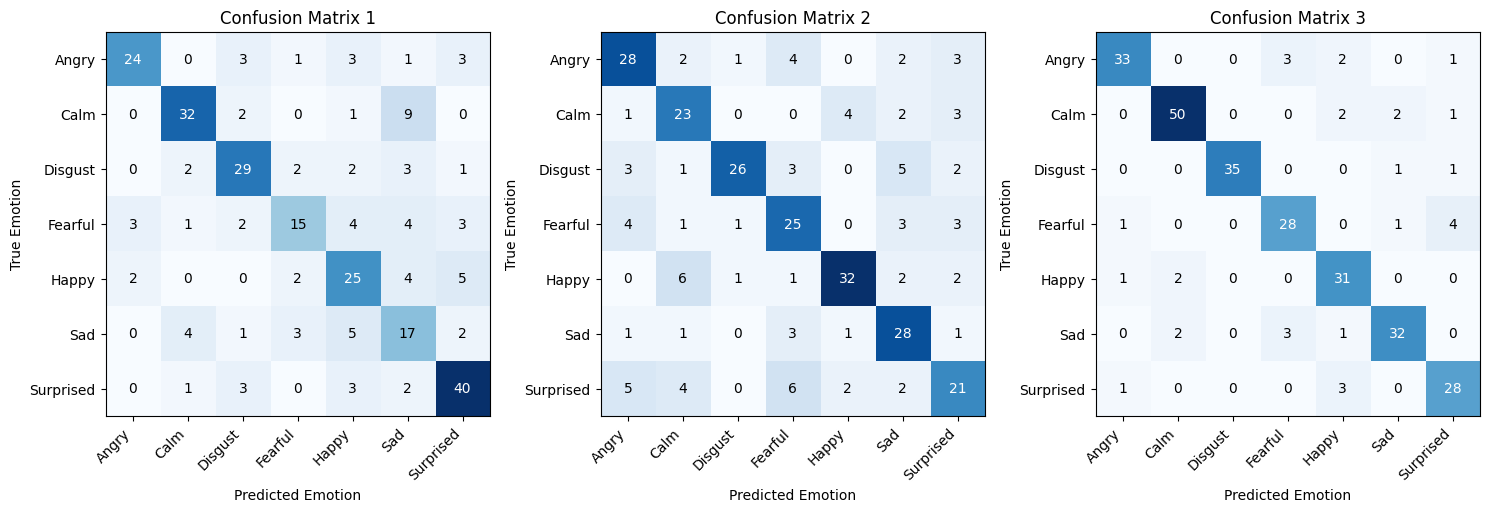

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create confusion matrices
cm1 = confusion_matrix(y_test1, y_pred1)
cm2 = confusion_matrix(y_test2, y_pred2)
cm3 = confusion_matrix(y_test3, y_pred3)

# Create subplots for three confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

confusion_matrices = [cm1, cm2, cm3]

for i, cm in enumerate(confusion_matrices):
    ax = axes[i]
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f'Confusion Matrix {i+1}')
    ax.set_xlabel('Predicted Emotion')
    ax.set_ylabel('True Emotion')
    ax.set_xticks(np.arange(len(np.unique(y_test1))))
    ax.set_yticks(np.arange(len(np.unique(y_test1))))
    ax.set_xticklabels(np.unique(y_test1), rotation=45, ha='right')
    ax.set_yticklabels(np.unique(y_test1))
    thresh = cm.max() / 2.0  # Define the threshold for text color
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

